In [19]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import geopandas as gpd
import matplotlib.pyplot as plt
import ee
import folium
import geemap.core as geemap
import geehydro
import math
import requests
import os
import skimage
import rasterio as rs
import time
import torch
import cv2
import PIL
from PIL import Image
from joblib import dump, load
from google.cloud import storage
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import LinearSVC
from sklearn import svm, metrics, ensemble
from keras.models import Sequential, Model, clone_model, save_model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, Flatten, MaxPool2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.regularizers import l2, l1
from torchvision.models.segmentation import deeplabv3_resnet50, deeplabv3_resnet101
from torchvision.models.segmentation import (
                                             DeepLabV3_ResNet50_Weights, 
                                             DeepLabV3_ResNet101_Weights, 
                                            )




In [35]:
# ensure directories are made if they do not exist
def checkdirs(path):
    if not(os.path.exists(path)):
        os.makedirs(path)

## crop images to middle 256x256 pixels
def crop(img):
    height, width = img.shape[0:2]
    new = 256

    left = int((width - new)/2)
    top = int((height - new)/2)
    right = int((width + new)/2)
    bottom = int((height + new)/2)

    # print(left,top,right,bottom)
    crop = img[top:bottom,left:right,:]
    # print(crop.shape)
    return crop

## get labels from completed csv file
def get_Labels(csvF="400labels.csv"):
    l = pd.read_csv(csvF)

    found = l.loc[l.Index==1002].Label.squeeze()
    missing = l.loc[l.Index==1003].Label.squeeze()
   

    # print(type(found))
    # print(type(missing))

    labelDF = pd.DataFrame(np.nan,index=list(range(2240)),columns=list(l.columns))

    labelDF.Index = labelDF.index+1
    labelDF.tail()
    for val in list(l.Index.squeeze()):
        label2Add = int(l.loc[l.Index==val].Label.squeeze())
        # print(label2Add)
        labelDF.loc[labelDF.Index==val,"Label"]=label2Add
    labelDF.loc[labelDF.Index==1001]

    # np.array(labelDF)
    return labelDF

def get_sets(csv="400labels.csv"):
    labelDF = get_Labels(csv)
    imgList = []
    y_list = []

    labelDF.tail()
    for i in list(labelDF.dropna().Index.squeeze()):
        y_list.append(int(labelDF.loc[labelDF["Index"]==i].Label.squeeze()))
        imgList.append(getImage(i)[0])
    return imgList, y_list

## get picture name (in GCS name scheme)
def getImageName(i):
    fname = f"pipeline{i}.tif"
    raw_filename = './images/'+fname

    return raw_filename

# set up reference to GCS
def getImage(p,sections):
    fname = f"enhanced_pipeline_{p}_{sections}.tif"
    raw_filename = './images/'+fname
    BUCKET_NAME = 'gee_image_exports' # change to 'gee_image_exports'
    # put service account key after from_service_account_json() if necessary
    storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-ee201daa0dab.json")
    raw_blobname = "USDA_aerials/"+fname # change to f'USDA_aerials/{raw_filename}'
    checkdirs("./images")

    ## actually grab from cloud storage bucket
    blob = storage_client.bucket(
    BUCKET_NAME).blob(raw_blobname)
    # blob = storage.Client(project="pipeline-elevation-project").bucket(
    # BUCKET_NAME).blob(raw_blobname)
    start = time.time()
    blob.download_to_filename(raw_filename)
    end = time.time()
    print(f"Time taken for download:\n\t{end-start} seconds.")

    raster = rs.open(raw_filename)
    array = raster.read()
    # rgb image
    dPic = np.dstack((array[0],array[1],array[2]))

    #ndvi image (channel 1: R band; channel 2: NIR band; channel 3: NDVI)
    
    return crop(dPic)

# label CSV 
def labelCSV(labelDict, fname="labels.csv"):
    # save labels to csv
    import csv
    with open(fname,'w',newline='\n') as f:
        wr = csv.writer(f, quoting=csv.QUOTE_ALL)
        wr.writerow(["Index","Label"])
        for val in labelDict.keys():
            wr.writerow([val,labelDict[val]])

    print("done")

def getVal(n):
    return int(n>=0.5)


In [5]:
fname = f"pipeline_segments.geojson"
raw_filename = './data/'+fname
BUCKET_NAME = 'pipeline_data_bucket' # change to 'gee_image_exports'
# put service account key after from_service_account_json() if necessary
storage_client = storage.Client.from_service_account_json(r"C:\Users\toliv\Downloads\pipeline-elevation-project-ee201daa0dab.json")
raw_blobname = "raw/"+fname # change to f'USDA_aerials/{raw_filename}'
checkdirs("./data")

## actually grab from cloud storage bucket
blob = storage_client.bucket(
BUCKET_NAME).blob(raw_blobname)
# blob = storage.Client(project="pipeline-elevation-project").bucket(
# BUCKET_NAME).blob(raw_blobname)
start = time.time()
blob.download_to_filename(raw_filename)
end = time.time()
print(f"Time taken for download:\n\t{end-start} seconds.")

Time taken for download:
	8.04896330833435 seconds.


In [6]:
gpd.read_file(raw_filename).head()

,TYPEPIPE,Operator,Status,Shape_Leng,Shape_Le_1,pipe_id,unique_id,geometry
0,Interstate,El Paso Natural Gas Co,Operating,0.025148,0.016497,1147,1,"LINESTRING (380969.243 1087985.820, 381051.729..."
1,Interstate,El Paso Natural Gas Co,Operating,0.196085,0.196085,1154,2,"LINESTRING (381093.841 1090067.229, 381077.931..."
2,Interstate,El Paso Natural Gas Co,Operating,0.004100,0.004100,1155,3,"LINESTRING (381051.729 1089410.064, 381077.931..."
3,Interstate,El Paso Natural Gas Co,Operating,0.048014,0.028729,1162,4,"LINESTRING (380833.020 1110697.460, 380829.852..."
4,Interstate,El Paso Natural Gas Co,Operating,0.016974,0.016974,1163,5,"LINESTRING (380017.887 1110166.881, 379208.473..."


In [20]:
# py 3.12
# AbsModel = load("saved_models/absoluteBinaryModel.joblib")
AbsModel = load_model("saved_models/absoluteBinaryModel.keras")



In [22]:
[pic.shape for pic in predList]

[(256, 256, 3), (256, 256, 3), (256, 256, 3), (256, 256, 3)]

In [51]:
predList = [getImage(1102,276),getImage(1164,682),getImage(1005,2212),getImage(1005,2296)]
predictions = AbsModel.predict(np.stack(predList,axis=0))


Time taken for download:
	3.8884027004241943 seconds.
Time taken for download:
	1.9053137302398682 seconds.
Time taken for download:
	3.234873056411743 seconds.
Time taken for download:
	3.477565050125122 seconds.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


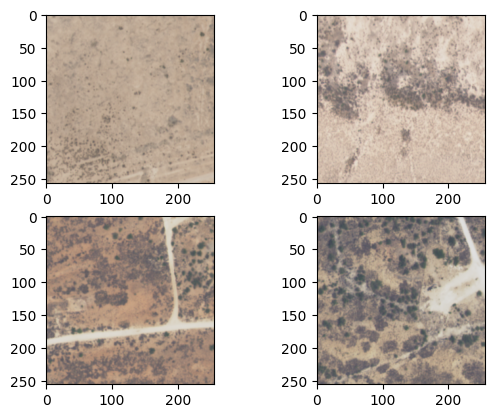

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

From the top-left and ending at the bottom right...
Image 0 was classified as 0.
Image 1 was classified as 0.
Image 2 was classified as 0.
Image 3 was classified as 0.


In [53]:
fig, ax = plt.subplots(int(math.sqrt(len(predList))),int(math.sqrt(len(predList))))

plt.figure(figsize=(10, 5))
ax[0,0].imshow(predList[0], cmap='viridis')
plt.figure(figsize=(10, 5))
ax[0,1].imshow(predList[1], cmap='viridis')
plt.figure(figsize=(10, 5))
ax[1,0].imshow(predList[2], cmap='viridis')
plt.figure(figsize=(10, 5))
ax[1,1].imshow(predList[3], cmap='viridis')
        

plt.show()

print("From the top-left and ending at the bottom right...")
for i in range(len(predList)):
    print(f"Image {i} was classified as {getVal(predictions[i][0])}.")


In [ ]:

distances_train = []
for i in range(len(x_train)):
    distance = np.linalg.norm(x_train[i].flatten() - x_val.flatten())
    distances_train.append(distance)

most_dissimilar_train_index = np.argmax(y_train)
most_dissimilar_train_image = x_train[most_dissimilar_train_index]

distances_train = []
for i in range(len(x_train)):
    distance = np.linalg.norm(x_train[i].flatten() - x_val.flatten())
    distances_train.append(distance)

most_similar_train_index = np.argmin(distances_train)
most_similar_train_image = x_train[most_similar_train_index]

distances_test = []
for i in range(len(x_test)):
    distance = np.linalg.norm(x_test[i].flatten() - avg_shoe_test.flatten())
    distances_test.append(distance)

most_dissimilar_test_index = np.argmax(distances_test)
most_dissimilar_test_image = x_test[most_dissimilar_test_index]

distances_test = []
for i in range(len(x_test)):
    distance = np.linalg.norm(x_test[i].flatten() - avg_shoe_test.flatten())
    distances_test.append(distance)

most_similar_test_index = np.argmin(distances_test)
most_similar_test_image = x_test[most_similar_test_index]

plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(most_dissimilar_train_image, cmap='gray')
plt.title('Most dissimilar in training data')

plt.subplot(2, 2, 2)
plt.imshow(most_similar_train_image, cmap='gray')
plt.title('Most similar  in training data')

plt.subplot(2, 2, 3)
plt.imshow(most_dissimilar_test_image, cmap='gray')
plt.title('Most dissimilar in testing data')

plt.subplot(2, 2, 4)
plt.imshow(most_similar_test_image, cmap='gray')
plt.title('Most similar  in testing data')

plt.show()

# Q3.1: What is the index of most similar shoe image in the training set:
print("Most similar shoe index in training set:", most_similar_train_index)

# Q3.2: What is the index of most dissimilar shoe image in the training set:
print("Most dissimilar shoe index in training set:", most_dissimilar_train_index)

# Q3.1: What is the index of most dissimilar shoe image in the testing set:
print("Most dissimilar shoe index in testing set:", most_dissimilar_test_index)

